In [2]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
import matplotlib
import cartopy as cart
import statistics
from scipy import stats

In [3]:
prw_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_prw_33model_piControl_2x2_last250.nc')

precip_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_pr_39model_piControl_2x2_last250.nc')

land_mask = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_landmask_31model.nc')

tas_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_tas_piControl_2x2_48mod_last250.nc')

ts_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_ts_39model_piControl_2x2_last250.nc')

In [4]:
mask = land_mask.mean('name')

In [14]:
def binning(var,models,latrange,temp,varname,temp_type,mini,maxi):
    var_mean = var.sel(name=models).isel(time=slice(len(var.time)-(30*12),
                                         len(var.time))).sel(lat=slice(-latrange,
                                                                       latrange)).mean('time').mean('name').to_dataset()
    
    temp_rolling = temp.sel(name=models).rolling(time=120, center=True).mean('time')
    temp_std = temp_rolling.std('time')
    temp_var = temp_std.mean('name').sel(lat=slice(-latrange,latrange))
    
    if temp_type == 'ts':
        var_mean = var_mean.where(mask<50)
        temp_var = temp_var.where(mask<50)
        print('TS masked')
        
    bin_edges = np.linspace(mini,maxi,15)
    print(bin_edges)
    
    var_mean['temp'] = temp_var
    var_mean_stack = var_mean.stack(z=('lat','lon'))
    var_mean_stack['tags'] = pd.cut(var_mean_stack[varname], bins=bin_edges, labels=bin_edges[:-1])
    var_mean_stats = var_mean_stack.groupby('tags').groups
    
    var_mean_binned = []
    var_std_binned = []
    for group in var_mean_stats:
        var_list = []
        for index in var_mean_stats[group]:
            var_list.append(var_mean_stack.temp[index].item())
        var_mean_binned.append(np.nanmean(var_list))
        var_std_binned.append(np.nanstd(var_list))
        
    plt.rcParams['figure.figsize'] = [12, 7]
    fig, ax1 = plt.subplots()
    ax1.errorbar(var_mean_stats.keys(), var_mean_binned, var_std_binned, capsize=5)
    ax1.scatter(var_mean_stats.keys(), var_mean_binned)
    ax1.set_ylabel(temp_type)
    #ax1.set_ylim(0.025,0.225)

    ax2 = ax1.twinx()
    gkde = stats.gaussian_kde(var_mean_stack[varname][~np.isnan(var_mean_stack[varname])])
    pdf = gkde.evaluate(np.linspace(var_mean_stack[varname].min(), var_mean_stack[varname].max(),200))
    #ax2.hist(omega_cont_mean_stack_tas['wap'], bin_edges_tas, density=True)
    ax2.plot(np.linspace(var_mean_stack[varname].min(), var_mean_stack[varname].max(), 200), pdf, color='orange')
    ax2.set_ylabel('PDF')

    ax1.set_xlabel(varname)

# PRW

In [ ]:
models_prw = ['ACCESS-CM2','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2',
              'CESM2-WACCM','CESM2-WACCM-FV2','CIESM','E3SM-1-0','EC-Earth3','EC-Earth3-Veg-LR','FGOALS-g3','GFDL-CM4',
              'GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-MM','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','MIROC6',
              'MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-MM','SAM0-UNICON','TaiESM1']

## -30 to 30

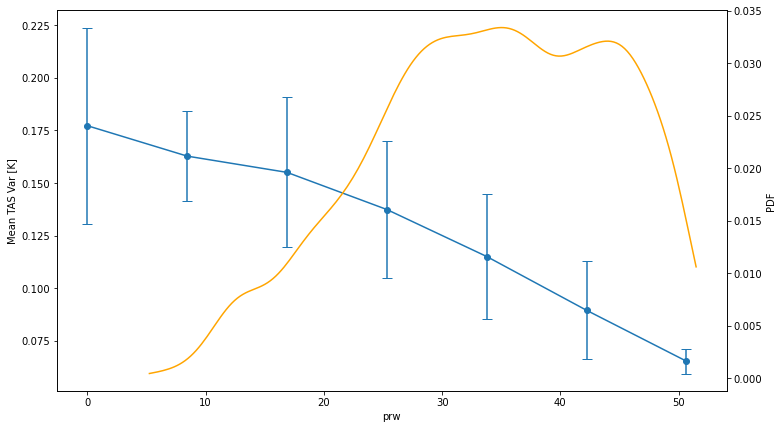

In [14]:
# TAS
binning(prw_cont,models_prw,30,tas_cont,'prw','tas')

In [19]:
models_prw_TS = ['ACCESS-CM2','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2',
              'CESM2-WACCM','CESM2-WACCM-FV2','CIESM','E3SM-1-0','EC-Earth3','EC-Earth3-Veg-LR','FGOALS-g3','GFDL-CM4',
              'GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-MM','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','MIROC6',
              'MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-MM','SAM0-UNICON','TaiESM1']

TS masked


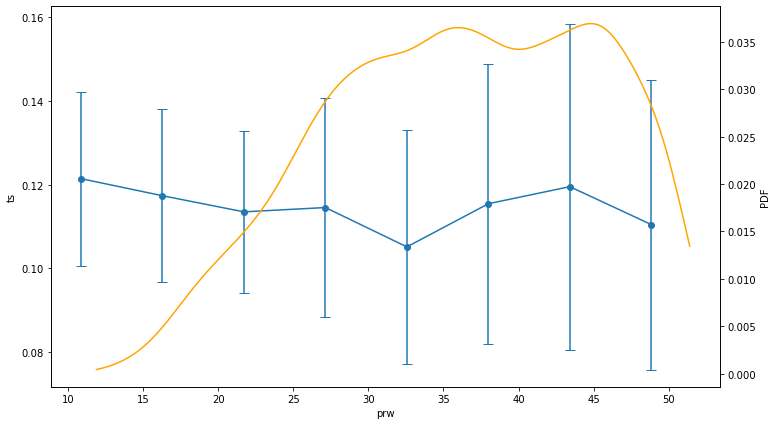

In [25]:
# TS
binning(prw_cont,models_prw_TS,30,ts_cont,'prw','ts')

## -20 to 20

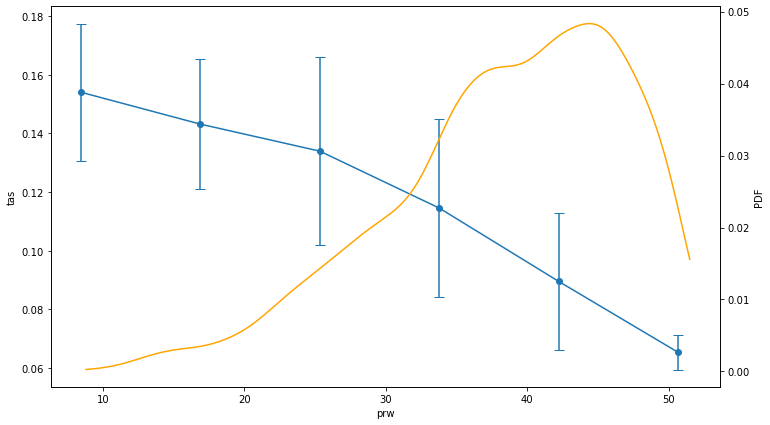

In [21]:
# TAS
binning(prw_cont,models_prw,20,tas_cont,'prw','tas')

TS masked


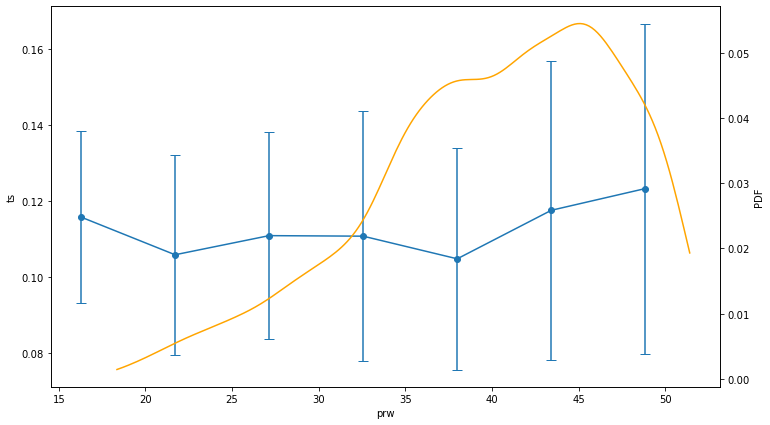

In [27]:
# TS
binning(prw_cont,models_prw_TS,20,ts_cont,'prw','ts')

# TS

In [5]:
models_ts = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2',
             'CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2','CIESM','CMCC-CM2-SR5','CMCC-ESM2','E3SM-1-0','E3SM-1-1',
             'EC-Earth3','EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4',
             'GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-MM','INM-CM4-8','INM-CM5-0','IPSL-CM5A2-INCA','IPSL-CM6A-LR','MIROC6',
             'MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-LM','NorESM2-MM','SAM0-UNICON','TaiESM1']

## -30 to 30

[275.  277.5 280.  282.5 285.  287.5 290.  292.5 295.  297.5 300.  302.5
 305.  307.5 310. ]


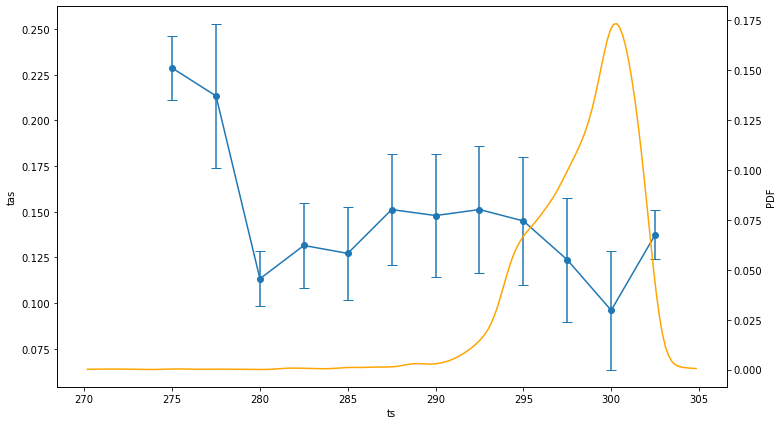

In [9]:
# TAS
binning(ts_cont, models_ts,30,tas_cont,'ts','tas',275,310)

TS masked
[290.         291.42857143 292.85714286 294.28571429 295.71428571
 297.14285714 298.57142857 300.         301.42857143 302.85714286
 304.28571429 305.71428571 307.14285714 308.57142857 310.        ]


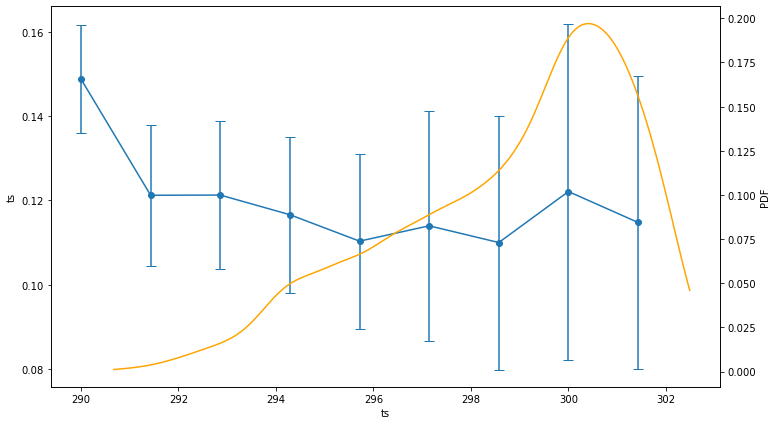

In [11]:
# TS
binning(ts_cont, models_ts,30,ts_cont,'ts','ts',290,310)

## -20 to 20

[275.  277.5 280.  282.5 285.  287.5 290.  292.5 295.  297.5 300.  302.5
 305.  307.5 310. ]


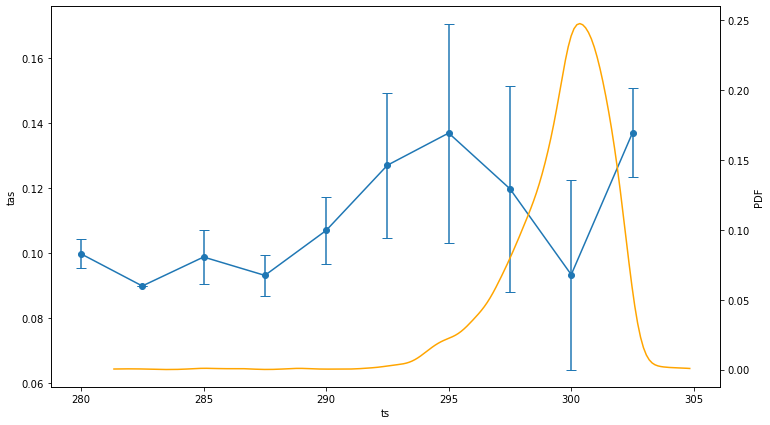

In [12]:
# TAS
binning(ts_cont, models_ts,20,tas_cont,'ts','tas',275,310)

TS masked
[290.         291.42857143 292.85714286 294.28571429 295.71428571
 297.14285714 298.57142857 300.         301.42857143 302.85714286
 304.28571429 305.71428571 307.14285714 308.57142857 310.        ]


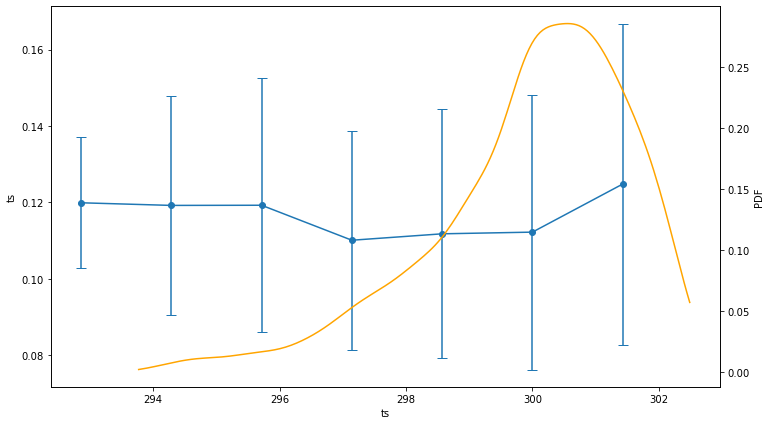

In [13]:
# TS
binning(ts_cont, models_ts,20,ts_cont,'ts','ts',290,310)

# PR

In [1]:
models_pr = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2',
             'CESM2-WACCM','CESM2-WACCM-FV2','CMCC-CM2-SR5','CMCC-ESM2','E3SM-1-0','E3SM-1-1','EC-Earth3','EC-Earth3-AerChem',
             'EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-MM','INM-CM4-8',
             'INM-CM5-0','IPSL-CM5A2-INCA','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1',
             'NorESM2-LM','NorESM2-MM','SAM0-UNICON','TaiESM1']

## -30 to 30

[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]


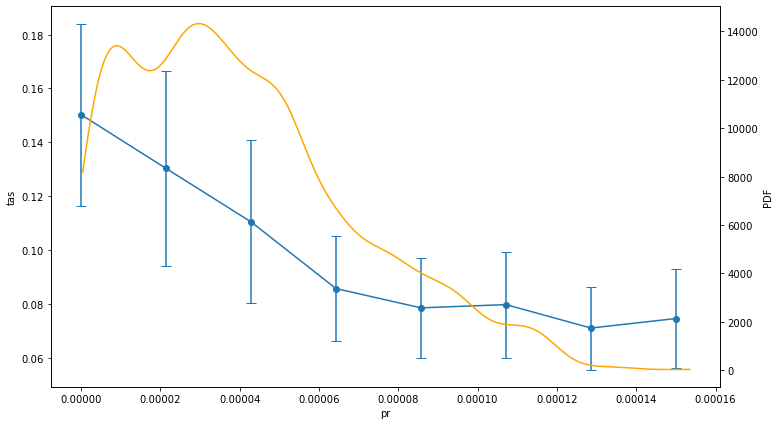

In [15]:
# TAS
binning(precip_cont, models_pr, 30, tas_cont, 'pr', 'tas', 0, 0.0003)

TS masked
[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]


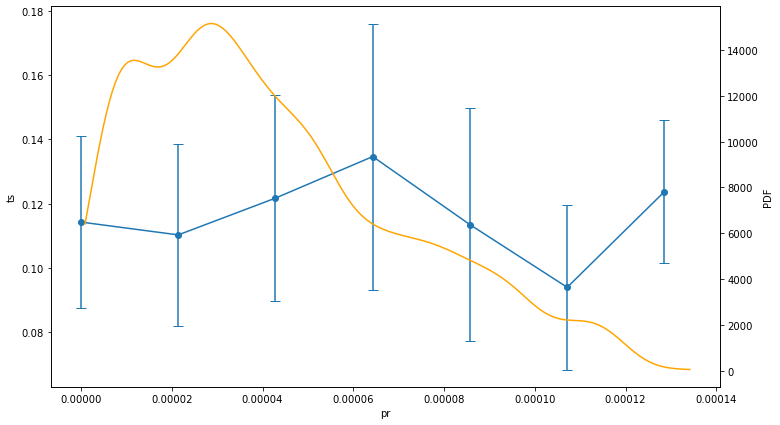

In [16]:
# TS
binning(precip_cont, models_pr, 30, ts_cont, 'pr', 'ts', 0, 0.0003)

## -20 to 20

[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]


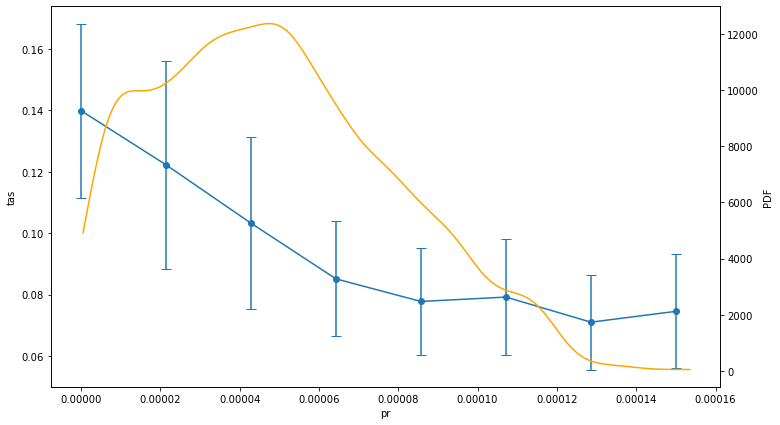

In [17]:
# TAS
binning(precip_cont, models_pr, 20, tas_cont, 'pr', 'tas', 0, 0.0003)

TS masked
[0.00000000e+00 2.14285714e-05 4.28571429e-05 6.42857143e-05
 8.57142857e-05 1.07142857e-04 1.28571429e-04 1.50000000e-04
 1.71428571e-04 1.92857143e-04 2.14285714e-04 2.35714286e-04
 2.57142857e-04 2.78571429e-04 3.00000000e-04]


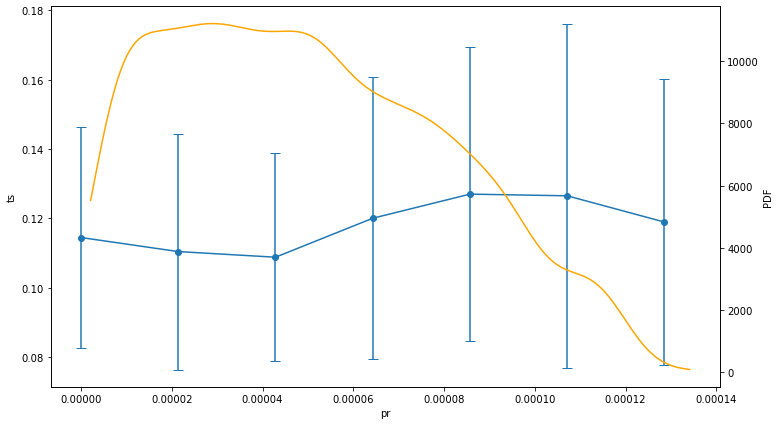

In [18]:
# TS
binning(precip_cont, models_pr, 20, ts_cont, 'pr', 'ts', 0, 0.0003)